# Sample, Explore, and Clean Taxifare Dataset 

**Objectives**
- Run a query on BigQuery
- Sample from large dataset in a reproducible way
- Explore data using Spark
- Identify corrupt data and clean accordingly

## Introduction 
In this notebook, we will explore a dataset corresponding to taxi rides in New York City to build a Machine Learning model that estimates taxi fares. The idea is to suggest an expected fare to taxi riders. Such a model would also be useful for ride-hailing apps that quote you the trip price in advance.

### Set up environment variables and load necessary libraries

In [3]:
import os

import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage

# Explicitly create a credentials object. This allows you to use the same
# credentials for both the BigQuery and BigQuery Storage clients, avoiding
# unnecessary API calls to fetch duplicate authentication tokens.
credentials, your_project_id = google.auth.default(
    scopes=["https://www.googleapis.com/auth/cloud-platform"]
)
# Make clients.
bqclient = bigquery.Client(credentials=credentials, project=your_project_id,)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

In [4]:
PROJECT = "saberbf-2020"  # Replace with your PROJECT
REGION = "us-east1"       # Choose an available region for Cloud MLE

os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION

Check that the Google BigQuery library is installed and if not, install it. 

In [5]:
!pip freeze | grep google-cloud-bigquery || pip install google-cloud-bigquery

google-cloud-bigquery==1.26.1
google-cloud-bigquery-storage==1.0.0


In [6]:
%reload_ext google.cloud.bigquery

## View data schema and size

The NYC taxi cab dataset is hosted in [BigQuery](https://cloud.google.com/bigquery/) under `nyc-tlc.yellow.trips`. It is a publically available dataset with a GCP account (click [here](https://console.cloud.google.com/bigquery?project=bigquery-public-data&p=nyc-tlc&d=yellow&t=trips&page=table) to acess the dataset).


## Preview data

There are over 1 Billion rows in this dataset and it's 130GB large, a real meaning of Big Data!!!

To sample the data deterministicly, we use a hash function and then sample using the modulo operation on the hashed value. The hash values are obtained using:

`FARM_FINGERPRINT(CAST(hashkey AS STRING))`

Where:

- `FARM_FINGERPRINT()`: Hashes strings to 64bit integers
- `CAST()`: Casts hashkey to string


Given these properties we can sample our data repeatably using the modulo operation. We'll use `pickup_datetime` as our hash key because it meets our desired properties. If such a column doesn't exist in the data you can synthesize a hashkey by concatenating multiple columns. Below we sample 1/5000th of the data. 

In [7]:
%%bigquery --project $PROJECT
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
WHERE 
    -- repeatable 1/5000th sample
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 5000)) = 1

vendor_id           pickup_datetime          dropoff_datetime  \
0            VTS 2013-04-16 11:43:00+00:00 2013-04-16 11:45:00+00:00   
1            VTS 2014-05-14 08:12:00+00:00 2014-05-14 08:14:00+00:00   
2            VTS 2013-11-07 23:18:00+00:00 2013-11-07 23:20:00+00:00   
3            VTS 2013-03-15 21:06:00+00:00 2013-03-15 21:08:00+00:00   
4            CMT 2013-06-16 21:18:08+00:00 2013-06-16 21:20:31+00:00   
...          ...                       ...                       ...   
224005       CMT 2009-02-09 15:00:26+00:00 2009-02-09 15:16:03+00:00   
224006       VTS 2012-06-14 19:17:00+00:00 2012-06-14 19:38:00+00:00   
224007       VTS 2010-10-25 17:15:00+00:00 2010-10-25 17:35:00+00:00   
224008       VTS 2009-03-15 14:13:00+00:00 2009-03-15 14:33:00+00:00   
224009       VTS 2010-04-22 22:36:00+00:00 2010-04-22 22:52:00+00:00   

        pickup_longitude  pickup_latitude  dropoff_longitude  \
0             -73.970498        40.756250         -73.969338   
1             -73.991292        40.750155         -73.994085   
2             -74.004047        40.738797         -74.005405   
3             -73.990295        40.755832         -73.990295   
4             -73.979603        40.767133         -73.973019   
...                  ...              ...                ...   
224005        -74.005087        40.737375         -73.971849   
224006        -73.949033        40.776772         -73.988250   
224007        -73.870917        40.773798         -73.921317   
224008        -73.995480        40.739350         -73.950365   
224009        -73.988250        40.723450         -73.953403   

        dropoff_latitude rate_code  passenger_count  trip_distance  \
0              40.757248         1                1           0.10   
1              40.746215         1                1           0.33   
2              40.739675         1                1           0.16   
3              40.755832         1                1           0.37   
4              40.764341         1                1           0.40   
...                  ...       ...              ...            ...   
224005         40.761093      None                1           3.00   
224006         40.764200         1                1           3.12   
224007         40.739658         1                1           4.65   
224008         40.785610      None                1           4.48   
224009         40.786890         1                1           0.55   

       payment_type  fare_amount  extra  mta_tax  imp_surcharge  tip_amount  \
0               CSH          3.5    0.0      0.5            NaN        0.00   
1               CSH          3.5    0.0      0.5            NaN        0.00   
2               CSH          3.5    0.5      0.5            NaN        0.00   
3               CSH          4.0    0.5      0.5            NaN        0.00   
4               CRD          4.0    0.5      0.5            NaN        0.50   
...             ...          ...    ...      ...            ...         ...   
224005          CRD         10.9    0.0      NaN            NaN        2.72   
224006          CRD         12.9    1.0      0.5            NaN        2.78   
224007          CRD         14.9    1.0      0.5            NaN        2.00   
224008          CSH         14.9    0.0      NaN            NaN        0.00   
224009          CAS         14.9    0.5      0.5            NaN        0.00   

        tolls_amount  total_amount store_and_fwd_flag  
0                0.0          4.00               None  
1                0.0          4.00               None  
2                0.0          4.50               None  
3                0.0          5.00               None  
4                0.0          5.50                  N  
...              ...           ...                ...  
224005           0.0         13.62                  N  
224006           0.0         17.18               None  
224007           0.0         18.40               None  
224008           0.0   

## Load sample into Pandas dataframe

We can supplement SQL analysis with Python analysis. A popular Python library for data analysis on structured data is [Pandas](https://pandas.pydata.org/).

To store BigQuery results in a Pandas DataFrame we do the following:

In [8]:
%%time

bq = bigquery.Client(project=PROJECT)

query_string = """
#standardSQL
SELECT
    *
FROM
    `nyc-tlc.yellow.trips`
Where
    -- repeatable 1/5000th sample
    ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 5000)) = 1
"""

trips = bq.query(query_string).to_dataframe()
trips.head()

CPU times: user 557 ms, sys: 113 ms, total: 670 ms
Wall time: 4.83 s


## Explore the data

It would be useful to understand the distribution of each of our columns, which is to say the mean, min, max, standard deviation etc..

In [12]:
# trips.describe(include='all')
trips.describe()

pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
count     224010.000000    224010.000000      224008.000000     224008.000000   
mean         -72.567277        39.975019         -72.568600         39.953818   
std           17.184744        11.531709          14.173995         12.181259   
min        -3327.388155     -2108.147765       -2084.468870      -2587.703973   
25%          -73.992087        40.735032         -73.991471         40.734159   
50%          -73.981826        40.752635         -73.980220         40.753110   
75%          -73.967239        40.767140         -73.963937         40.768102   
max         3442.185068      2614.663005        3442.185068       2958.581502   

       passenger_count  trip_distance    fare_amount          extra  \
count    224010.000000  224010.000000  224010.000000  224010.000000   
mean          1.687076       2.830173      11.127325       0.287398   
std           1.317762       3.307880       9.095850       0.348067   
min           0.000000       0.000000     -52.000000      -0.500000   
25%           1.000000       1.020000       6.000000       0.000000   
50%           1.000000       1.750000       8.500000       0.000000   
75%           2.000000       3.140000      12.500000       0.500000   
max          49.000000      97.300000     412.640000       1.500000   

             mta_tax  imp_surcharge     tip_amount   tolls_amount  \
count  193917.000000   15103.000000  224010.000000  224010.000000   
mean        0.496207       0.297239       1.092133       0.215548   
std         0.047469       0.028856       1.951176       1.087451   
min        -1.000000      -0.300000       0.000000       0.000000   
25%         0.500000       0.300000       0.000000       0.000000   
50%         0.500000       0.300000       0.000000       0.000000   
75%         0.500000       0.300000       1.720000       0.000000   
max         0.500000       0.300000     100.000000      23.500000   

        total_amount  
count  224010.000000  
mean       13.173473  
std        10.879476  
min       -52.800000  
25%         7.150000  
50%        10.000000  
75%        14.600000  
max       412.640000

At the first glance, we notice that: 

- `min` and `max` of Latitudes (should be between -90 and 90), and longitudes (should be between -180 and 180) are off the range, so clearly some of this data is misleading and should be removed or corrected.

- some trip fares are negative and some passenger counts are 0 which doesn't seem right. They need to be cleaned up.

- some trip distances are 0, but it appears that passengers are being charged substantial fares, despite.


In [ ]:
trips[trips["trip_distance"] == 0][:10] # first 10 rows with trip_distance == 0

Let's graph `trip_distance` vs `fare_amount`.

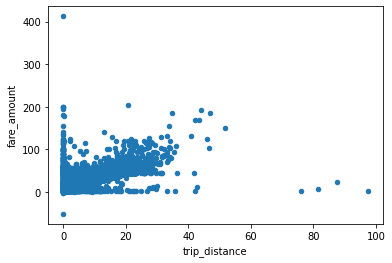

In [14]:
%matplotlib inline
_ = trips.plot(x = "trip_distance", y = "fare_amount", kind = "scatter")

It appears that we have a lot of invalid data samples being coded as zero distance and some fare amounts that are definitely illegitimate. To remove them from the query, we only keep trips longer than zero miles and fare amounts bigger than ($2.50). 

Also, we can combine the sum of `fare_amount` and `tolls_amount` into a the `fare_amount`.

## Select useful fields

What fields do you see that may be useful in modeling taxifare? They should be

1. Related to the objective: for example we know `passenger_count` shouldn't have any affect on fare because fare is calculated by time and distance.
2. Available at prediction time: for example `trip_distance` is certainly related to the objective, but not available until a trip is completed

We will use `pickup_datetime`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, and `dropoff_latitude`.

## Clean the data

Based on what we discussed so far, here is the proposed clean-up process for the data:

- Filter to latitudes and longitudes that are reasonable for NYC
- Throw out fare amounts < $2.50
- Trip distances and passenger counts should be non-zero
- Have the label reflect the sum of `fare_amount` and `tolls_amount`

Let's change the BigQuery query appropriately, and only return the fields we'll use in our model.

In [19]:
query_string = '''
SELECT
    -- add new label
    (tolls_amount + fare_amount) AS fare_amount, -- label
    -- select features
    pickup_datetime,
    pickup_longitude, 
    pickup_latitude, 
    dropoff_longitude, 
    dropoff_latitude
FROM
    `nyc-tlc.yellow.trips`
WHERE
    -- Clean Data
    trip_distance > 0
    AND passenger_count > 0
    AND fare_amount >= 2.5
    AND pickup_longitude > -74.2
    AND pickup_longitude < -73.7
    AND dropoff_longitude > -74.2
    AND dropoff_longitude < -73.7
    AND pickup_latitude >40.5
    AND pickup_latitude < 41
    AND dropoff_latitude > 40.5
    AND dropoff_latitude < 41
    -- repeatable 1/5000th sample
    AND ABS(MOD(FARM_FINGERPRINT(CAST(pickup_datetime AS STRING)), 5000)) = 1'''

We now have a repeatable and clean sample we can use for modeling taxi fares. 

In [20]:
trips = bq.query(query_string).to_dataframe()
trips.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0        16.33 2014-06-18 01:46:00+00:00        -73.978640        40.741857   
1        17.00 2014-04-27 00:24:35+00:00        -73.993629        40.767209   
2        18.00 2013-04-16 11:43:00+00:00        -74.011897        40.704712   
3        19.00 2013-11-05 17:28:42+00:00        -73.953241        40.782620   
4        20.00 2015-04-10 13:42:00+00:00        -74.000191        40.714275   

   dropoff_longitude  dropoff_latitude  
0         -73.954962         40.734732  
1         -73.945785         40.835910  
2         -73.993012         40.738862  
3         -73.991682         40.749183  
4         -73.983543         40.764706

In [ ]:
from joblib import dump, load

#Features:
# pickup time : scaled time of day --> float (0,1)
# pickup location: Bin locations and one-hot encode
# dropoff location: Bin locations and one-hot encode
# Distance: Crow fly distance, 

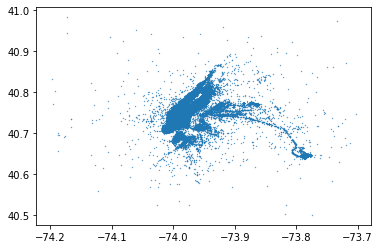

In [22]:
import matplotlib.pyplot as plt

_ = plt.scatter(trips["pickup_longitude"], trips["pickup_latitude"], s= 0.1)



In [ ]:
from sklearn.cluster import KMeans
import numpy as np

In [ ]:
import pandas as pd
def make_geographical_features(data):
    
    
    coarse_clustering, fine_clustering = load("/home/BigData/Final/location_clustering.models")

    print(coarse_clustering.cluster_centers_)
    coarse_clusters= coarse_clustering.predict(trips[["pickup_longitude","pickup_latitude"]])
    per_cluster_data = [trips.loc[coarse_clusters==i] for i in [0,1]]
    fine_clusters = fine_clustering.predict(per_cluster_data[0][["pickup_longitude","pickup_latitude"]])
    
    per_cluster_data[0]["geographical_cluster"] = fine_clusters
    per_cluster_data[1]["geographical_cluster"] = np.zeros(len(per_cluster_data[1]))+np.max(fine_clusters)+1
    full = pd.concat(per_cluster_data)
    return full
    

In [ ]:
trips_with_cluster = make_geographical_features(trips)


In [ ]:
plt.scatter(trips_with_cluster["pickup_longitude"], trips_with_cluster["pickup_latitude"], s= 0.1, c = trips_with_cluster["geographical_cluster"])

In [ ]:
trips_with_cluster["pickup_hour"] = [i.hour -12 for i in trips_with_cluster["pickup_datetime"]]

In [ ]:
def calc_distance(trip):
    
    x1,y1 = trip["pickup_longitude"],trip["pickup_latitude"]
    x2,y2 = trip["dropoff_longitude"],trip["dropoff_latitude"]
    dist = np.sqrt((y2-y1)**2 + (x2-x1)**2)
    return np.nan if dist == 0 else dist

In [ ]:
trips_with_cluster["crowfly_dist"] = trips_with_cluster.apply(calc_distance,axis = 1)

In [ ]:
trips_with_cluster= trips_with_cluster.dropna()

In [ ]:
trips_with_cluster.head()

In [ ]:
def to_onehot(n,mx):
    res= np.zeros((mx,))
    res[n] = 1
    return res

In [ ]:
def entry_to_point(trip):
    values = np.array([trip["pickup_hour"]/12,np.log(trip["crowfly_dist"])])
    onehot_location= to_onehot(int(trip["geographical_cluster"]),11)
    values=  np.concatenate([values,onehot_location])
    return values

In [ ]:
X = trips_with_cluster.apply(entry_to_point,axis = 1).values
X = np.array([x for x in X])

In [ ]:
y = trips_with_cluster["fare_amount"].values

In [ ]:
X[:,1] =( X[:,1] - np.mean(X[:,1]))/np.std(X[:,1])

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
lreg = Ridge()
lreg.fit(X_train,y_train)
lreg.score(X_test,y_test)

In [ ]:
svr = SVR(cache_size=7000)
svr.fit(X_train,y_train)
svr.score(X_test,y_test)